<a href="https://colab.research.google.com/github/soumendra/cnn-visualisation/blob/master/notebooks/visualising_and_interpreting_cnns_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

![](https://github.com/soumendra/cnn-visualisation/blob/master/notebooks/assets/promiscuous_dlmodel.png?raw=1)

1. Build a small model
2. Visualisation technique 1
3. Visualisation technique 2
4. Visualisation technique 3
5. Real-life Demo

# Colab specific updates

In [1]:
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-4bqxnsn2
  Running setup.py bdist_wheel for keras-vis ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-n2o8zrtb/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


# Build a small MNIST Model

* Step 1: Build model
* Step 2: Compile
* Step 3: Train
* Step 4: Test

## Data Prep

In [2]:
import numpy as np
import keras

from keras.datasets import mnist
from keras import backend as K

num_classes = 10


# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## The MNIST Model

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D

batch_size = 128
epochs = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 169us/step - loss: 0.2360 - acc: 0.9276 - val_loss: 0.0486 - val_acc: 0.9836
Epoch 2/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.0824 - acc: 0.9749 - val_loss: 0.0407 - val_acc: 0.9856
Epoch 3/5
60000/60000 [==============================] - 8s 134us/step - loss: 0.0632 - acc: 0.9807 - val_loss: 0.0348 - val_acc: 0.9889
Epoch 4/5
60000/60000 [==============================] - 8s 134us/step - loss: 0.0523 - acc: 0.9840 - val_loss: 0.0342 - val_acc: 0.9888
Epoch 5/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.0465 - acc: 0.9851 - val_loss: 0.0292 - val_acc: 0.9896
Test loss: 0.029239640416105977
Test accuracy: 0.9896


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# Dense Layer Visualizations

* To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations.

* Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph.

* If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

* Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.

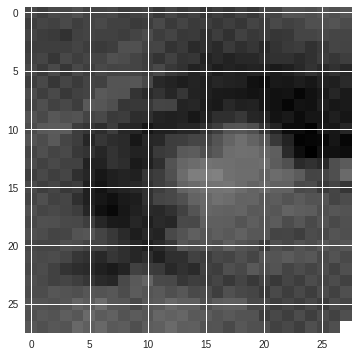

In [5]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didn't work very well.

The input to network is preprocessed to range (0, 1). We should specify input_range = (0., 1.) to constrain the input to this range.
The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use verbose=True and examine individual loss values.
Lets do these step by step and see if we can improve it.

# Debugging step 1: Specifying input_range



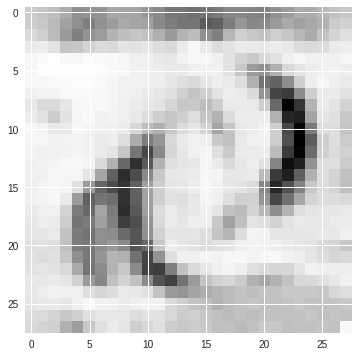

In [7]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])

Much better but still seems noisy. Lets examining the losses with verbose=True and tuning the weights.

# Debugging step 2: Tuning regularization weights

One of the issues with activation maximization is that the input can go out of the training distribution space. Total variation and L-p norm are used to provide some hardcoded image priors for natural images. For example, Total variation ensures that images are blobber and not scattered. Unfotunately, sometimes these losses can dominate the main ActivationMaximization loss.

Lets see what individual losses are, with verbose=True

Iteration: 1, named_losses: [('ActivationMax Loss', 0.0281808),
 ('L-6.0 Norm Loss', 0.019829264),
 ('TV(2.0) Loss', 0.08899963)], overall loss: 0.13700969517230988
Iteration: 2, named_losses: [('ActivationMax Loss', 5.923728),
 ('L-6.0 Norm Loss', 0.1730701),
 ('TV(2.0) Loss', 611.42487)], overall loss: 617.5216674804688
Iteration: 3, named_losses: [('ActivationMax Loss', -50.545033),
 ('L-6.0 Norm Loss', 0.1799535),
 ('TV(2.0) Loss', 137.45474)], overall loss: 87.08966064453125
Iteration: 4, named_losses: [('ActivationMax Loss', -112.270004),
 ('L-6.0 Norm Loss', 0.19367224),
 ('TV(2.0) Loss', 130.8023)], overall loss: 18.725975036621094
Iteration: 5, named_losses: [('ActivationMax Loss', -198.67648),
 ('L-6.0 Norm Loss', 0.21507221),
 ('TV(2.0) Loss', 117.25624)], overall loss: -81.20516967773438
Iteration: 6, named_losses: [('ActivationMax Loss', -308.8051),
 ('L-6.0 Norm Loss', 0.2504576),
 ('TV(2.0) Loss', 135.89627)], overall loss: -172.65838623046875
Iteration: 7, named_losses:

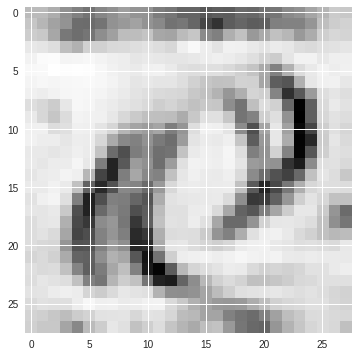

In [8]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])